# Special topics

This notebook contains some special topics and plots requested internally at Argovis. Public consumers should focus on our educational notebooks, starting with [Intro to Argovis](https://github.com/argovis/demo_notebooks/blob/main/Intro_to_Argovis.ipynb).

In [1]:
from argovisHelpers import helpers as avh
import datetime, pandas, matplotlib, scipy, numpy
import numpy as np
import helpers
import matplotlib.pyplot as plt
from matplotlib import cm

API_ROOT='https://argovis-api.colorado.edu/'
API_KEY=''

### Getting data from Argovis

In the following we ask Argovis to return profiles that have both temperature and salinity with QC = 1 (the best QC flag) in a region and time period of interest. If curious, try and run the notebook using 'data': 'temperature,salinity' in the following cell (instead of 'data': 'temperature,1,salinity,1'). The TS diagrams will look different as some data with bad QC will be returned, if we don't tell Argovis we only want QC = 1.

In [2]:
# get TS profiles in a region and time period of interest

pac_region = [[-155,-1.5],[-155,-30],[-145,-30],[-145,-1.5],[-155,-1.5]]
argo = {
    'startDate': '2022-12-30T00:00:00Z',
    'endDate': '2023-01-13T00:00:00Z',
    'polygon': pac_region,
    'data': 'temperature,1,salinity,1'
} # querying only profiles that have both temperature and salinity

floats = avh.query('argo', options=argo, apikey=API_KEY, apiroot=API_ROOT)

In [3]:
# let's select only levels that have a valid T and S
def delete_if_none(list1, list2, list3):
    result1 = []
    result2 = []
    result3 = []

    for i in range(len(list1)):
        if list1[i] is not None and list2[i] is not None and list3[i] is not None:
            result1.append(list1[i])
            result2.append(list2[i])
            result3.append(list3[i])

    return result1, result2, result3

def find_variable_index(profile, variable):
    return profile['data_info'][0].index(variable)


filtered_profiles = []
for f in floats:
    filtered_pressure, filtered_temperature, filtered_salinity = delete_if_none(f['data'][find_variable_index(f, 'pressure')], f['data'][find_variable_index(f, 'temperature')], f['data'][find_variable_index(f, 'salinity')])
    filtered_profiles.append([filtered_pressure, filtered_temperature, filtered_salinity])

In [4]:
# only makes sense for profiles that have levels spanning the region of interest

shallow = 10
deep = 1800

# select only profiles that have measurements in the range of interest
profiles = [f for f in filtered_profiles if f[0][0] < shallow and f[0][-1] > deep]

In [5]:
# interpolate temperature and salinity

levels = list(range(shallow,deep,5))

interpolated_temperatures = np.array([list(scipy.interpolate.pchip_interpolate(p[0], p[1], levels)) for p in profiles])
interpolated_salinity = np.array([list(scipy.interpolate.pchip_interpolate(p[0], p[2], levels)) for p in profiles])

In [6]:
# transpose and cast to various rectangular forms as desired

numpy.shape(interpolated_temperatures)

(33, 358)

### TS plot using scatter

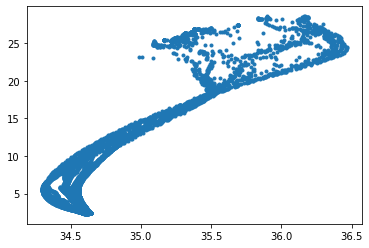

In [7]:
plt.plot(interpolated_salinity.flatten(),interpolated_temperatures.flatten(),marker='.',linestyle='')

### Joint PDF 

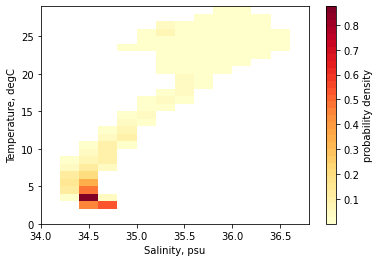

In [8]:
plt.hist2d(interpolated_salinity.flatten(),interpolated_temperatures.flatten(),density=True,
           bins=[np.arange(34,37,.2),np.arange(0,30,1)],
           cmin=1.e-100,cmap=cm.get_cmap('YlOrRd', 32))#'YlOrRd') #hot_r
plt.ylabel('Temperature, degC')
plt.xlabel('Salinity, psu')
cbar = plt.colorbar()
cbar.set_label('probability density')